In [1]:
import numpy as np
import pandas as pd
import pandas_ta as ta
from scipy.signal import argrelextrema
from numba import jit
from collections import Counter
import optuna
import joblib
import json
import gc
import traceback
import os
from datetime import datetime
import tensorflow as tf

# --------------------------------------------------------------------------------
# 1. 유틸리티 함수 (수정 불필요)
# --------------------------------------------------------------------------------
def add_indicator_to_df(df_ta, indicator):
    if indicator is None: return
    if isinstance(indicator, pd.DataFrame):
        for col in indicator.columns: df_ta[col] = indicator[col]
    elif isinstance(indicator, pd.Series):
        colname = indicator.name if indicator.name else 'Unnamed'
        df_ta[colname] = indicator

def safe_add(df_ta, func, *args, **kwargs):
    try:
        result = func(*args, **kwargs)
        add_indicator_to_df(df_ta, result)
        return True
    except:
        return False

# --------------------------------------------------------------------------------
# 2. 외부 데이터/파생변수 추가 함수 (수정 불필요)
# --------------------------------------------------------------------------------
def add_kimchi_premium_proxy(df):
    df_kp = df.copy()
    target_coins = ['ETH', 'BTC', 'XRP', 'SOL', 'ADA', 'DOGE', 'AVAX', 'DOT']
    
    for coin in target_coins:
        krw_col = f'{coin}_Close'
        bin_col = f'{coin}_Bin_Close'
        
        if krw_col in df_kp.columns and bin_col in df_kp.columns:
            ratio_col = f'{coin}_KP_Ratio'
            df_kp[ratio_col] = df_kp[krw_col] / (df_kp[bin_col] + 1e-9)
            
            ma = df_kp[ratio_col].rolling(180).mean()
            std = df_kp[ratio_col].rolling(180).std()
            df_kp[f'{coin}_KP_Zscore'] = (df_kp[ratio_col] - ma) / (std + 1e-9)
            
            df_kp[f'{coin}_KP_Change'] = df_kp[ratio_col].pct_change()

    return df_kp

def add_funding_and_onchain_features(df):
    df_on = df.copy()
    
    if 'fundingRate' in df_on.columns:
        df_on['FR_Abs_Signal'] = df_on['fundingRate'].abs()
        df_on['FR_Trend'] = df_on['fundingRate'].rolling(6).mean()
        df_on['FR_Change'] = df_on['fundingRate'].diff()

    tvl_cols = [col for col in df_on.columns if 'tvl' in col.lower()]
    for col in tvl_cols:
        df_on[f'{col}_1d_chg'] = df_on[col].pct_change(6)
        
    return df_on

def add_cross_crypto_correlations(df):
    df_corr = df.copy()
    other_coins = ['BTC', 'XRP', 'SOL', 'ADA', 'AVAX', 'DOT']
    eth_ret = df['ETH_Close'].pct_change()
    
    for coin in other_coins:
        col_name = f'{coin}_Close'
        if col_name in df.columns:
            coin_ret = df[col_name].pct_change()
            df_corr[f'Corr_ETH_{coin}_24h'] = eth_ret.rolling(6).corr(coin_ret)
            df_corr[f'RelStr_ETH_{coin}'] = eth_ret - coin_ret
            
    return df_corr

def add_price_lag_features_first_4h(df):
    df_new = df.copy()
    close = df['ETH_Close']
    for lag_days in [1, 2, 3, 5, 10]:
        lag_periods = lag_days * 6
        df_new[f'return_lag_{lag_periods}p'] = close.pct_change(periods=lag_periods).shift(1)
    return df_new

# --------------------------------------------------------------------------------
# 3. 기술적 지표 계산 함수 
# --------------------------------------------------------------------------------
def calculate_technical_indicators_4h(df):
    df = df.sort_values('date').reset_index(drop=True)
    df_ta = df.copy()

    close = df['ETH_Close']
    high = df.get('ETH_High', close)
    low = df.get('ETH_Low', close)
    volume = df.get('ETH_Volume', pd.Series(index=df.index, data=1))
    open_ = df.get('ETH_Open', close)

    # 1. Volatility (ATR)
    df_ta['ATR_84'] = ta.atr(high, low, close, length=84)
    
    # 2. Bollinger Bands
    bb = ta.bbands(close, length=120, std=2)
    if bb is not None:
        df_ta['BB_WIDTH'] = bb.iloc[:, 2]

    # 3. Moving Averages (SMA_200 추가됨)
    df_ta['SMA_120'] = ta.sma(close, length=120)
    df_ta['SMA_300'] = ta.sma(close, length=300)
    
    # [추가] 장기 추세선 (Regime Filter용)
    df_ta['SMA_200'] = ta.sma(close, length=200)
    # [추가] 상승/하락 국면 (1: 상승장, 0: 하락장) - 모델이 참고하기 좋음
    df_ta['REGIME_SMA200'] = (close > df_ta['SMA_200']).astype(int)

    df_ta['EMA_72'] = ta.ema(close, length=72)
    
    df_ta['TREND_SCORE'] = (close > df_ta['SMA_120']).astype(int) + (df_ta['SMA_120'] > df_ta['SMA_300']).astype(int)

    # 4. Momentum & Trend Strength
    df_ta['RSI_84'] = ta.rsi(close, length=84)
    safe_add(df_ta, ta.macd, close, fast=72, slow=156, signal=54)

    # [추가] ADX (추세 강도, Dynamic TP/SL용)
    adx = ta.adx(high, low, close, length=14)
    if adx is not None:

        df_ta['ADX_14'] = adx.iloc[:, 0]  # ADX 값
        df_ta['DMP_14'] = adx.iloc[:, 1] # +DI (옵션)
        df_ta['DMN_14'] = adx.iloc[:, 2] # -DI (옵션)

    # 5. Volume & MFI
    df_ta['OBV'] = ta.obv(close, volume)
    df_ta['MFI_84'] = ta.mfi(high, low, close, volume, length=84)
    df_ta['VOLUME_RATIO'] = volume / (volume.rolling(120).mean() + 1e-8)

    # 6. Candles & Patterns
    df_ta['UPPER_SHADOW'] = (high - np.maximum(close, open_)) / (high - low + 1e-9)
    df_ta['LOWER_SHADOW'] = (np.minimum(close, open_) - low) / (high - low + 1e-9)

    for window in [30, 120, 360]:
        swing_high = high.rolling(window).max().shift(1)
        swing_low = low.rolling(window).min().shift(1)
        
        df_ta[f'PRICE_VS_HIGH_{window}p'] = close / (swing_high + 1e-9)
        df_ta[f'PRICE_VS_LOW_{window}p'] = close / (swing_low + 1e-9)
        df_ta[f'BREAKOUT_STR_{window}p'] = (close - swing_high) / (df_ta['ATR_84'] + 1e-9)

    return df_ta

# --------------------------------------------------------------------------------
# 4. 변동성 Regime 추가 함수
# --------------------------------------------------------------------------------
def add_volatility_regime_features_4h(df):
    df_regime = df.copy()
    if 'ATR_84' in df.columns:
        atr_ma = df['ATR_84'].rolling(120).mean()
        df_regime['high_volatility_regime'] = (df['ATR_84'] > atr_ma).astype(int)
    
    # [추가] Bollinger Band Squeeze (변동성 수축 국면)
    if 'BB_WIDTH' in df.columns:
        # 최근 120봉 중 하위 20% 폭이면 Squeeze 상태 (폭발 임박)
        bbw_threshold = df['BB_WIDTH'].rolling(120).quantile(0.2)
        df_regime['is_squeeze'] = (df['BB_WIDTH'] < bbw_threshold).astype(int)
        
    return df_regime

# --------------------------------------------------------------------------------
# 5. 기타 파생변수 생성 함수 
# --------------------------------------------------------------------------------
def calculate_cumulative_volume_delta_4h(df):
    df_cvd = df.copy()
    close = df['ETH_Close']
    open_ = df.get('ETH_Open', close)
    volume = df.get('ETH_Volume', pd.Series(index=df.index, data=1))
    
    df_cvd['volume_delta'] = np.where(close > open_, volume, -volume)
    df_cvd['CVD'] = df_cvd['volume_delta'].cumsum()
    
    df_cvd['CVD_24h'] = df_cvd['volume_delta'].rolling(6).sum()
    df_cvd['CVD_7d'] = df_cvd['volume_delta'].rolling(42).sum()
    
    df_cvd['CVD_Rank_180'] = df_cvd['CVD_24h'].rolling(180).rank(pct=True)
    
    cvd_slope = df_cvd['CVD'].diff(6)
    price_volatility = close.rolling(24).std() + 1e-9
    df_cvd['CVD_Slope_Norm'] = cvd_slope / price_volatility 
    
    return df_cvd

def add_vwma_features_4h(df):
    df_vwma = df.copy()
    close = df['ETH_Close']
    volume = df.get('ETH_Volume', pd.Series(index=df.index, data=1))
    
    for period in [20, 50]:
        period_4h = period * 6
        vwma = (close * volume).rolling(period_4h).sum() / (volume.rolling(period_4h).sum() + 1e-9)
        df_vwma[f'Price_div_VWMA_{period}d'] = (close / (vwma + 1e-9)) - 1
        
    return df_vwma

def add_obv_divergence_features_4h(df):
    df_obv = df.copy()
    close = df['ETH_Close']
    volume = df.get('ETH_Volume', pd.Series(index=df.index, data=1))
    
    if 'OBV' not in df.columns:
        df_obv['OBV'] = ta.obv(close, volume)
    obv = df_obv['OBV']
    
    obv_ma_30 = obv.rolling(30).mean()
    obv_ma_60 = obv.rolling(60).mean()
    df_obv['OBV_Trend'] = np.where(obv_ma_30 > obv_ma_60, 1, -1)
    
    def is_pivot_high(series, window=2):
        center = series.shift(window)
        is_max = pd.Series(True, index=series.index)
        for i in range(1, window + 1):
            is_max &= (center > series.shift(window - i)) & (center > series.shift(window + i))
        return is_max

    def is_pivot_low(series, window=2):
        center = series.shift(window)
        is_min = pd.Series(True, index=series.index)
        for i in range(1, window + 1):
            is_min &= (center < series.shift(window - i)) & (center < series.shift(window + i))
        return is_min

    price_high = is_pivot_high(close, 2)
    obv_high = is_pivot_high(obv, 2)
    
    price_slope = close.diff(12)
    obv_slope = obv.diff(12)
    
    df_obv['Div_Bullish'] = ((price_slope < 0) & (obv_slope > 0)).astype(int)
    df_obv['Div_Bearish'] = ((price_slope > 0) & (obv_slope < 0)).astype(int)
    
    return df_obv

def add_vwap_anchored_features_4h(df):
    df_vwap = df.copy()
    
    if 'date' not in df_vwap.columns and 'timestamp' in df_vwap.columns:
        df_vwap['date'] = pd.to_datetime(df_vwap['timestamp'])
    else:
        df_vwap['date'] = pd.to_datetime(df_vwap['date'])
    
    close = df_vwap['ETH_Close']
    high = df_vwap.get('ETH_High', close)
    low = df_vwap.get('ETH_Low', close)
    
    if 'ETH_Volume' in df_vwap.columns:
        volume = df_vwap['ETH_Volume']
    elif 'volume' in df_vwap.columns: 
        volume = df_vwap['volume']
    else:
        volume = pd.Series(1, index=df_vwap.index)

    typical_price = (high + low + close) / 3
    
    df_vwap['day'] = df_vwap['date'].dt.date
    
    df_vwap['pv'] = typical_price * volume
    df_vwap['cum_pv'] = df_vwap.groupby('day')['pv'].cumsum()
    df_vwap['cum_vol'] = volume.groupby(df_vwap['day']).cumsum() 
    
    df_vwap['VWAP_Day'] = df_vwap['cum_pv'] / (df_vwap['cum_vol'] + 1e-9)
    df_vwap['Dist_from_VWAP'] = (close / df_vwap['VWAP_Day']) - 1
    
    df_vwap = df_vwap.drop(['day', 'pv', 'cum_pv', 'cum_vol'], axis=1, errors='ignore')
    
    return df_vwap

def add_institutional_footprint_features_4h(df):
    df_inst = df.copy()
    volume = df.get('ETH_Volume', pd.Series(index=df_inst.index, data=1))
    close = df_inst['ETH_Close']
    open_ = df_inst.get('ETH_Open', close)
    high = df_inst.get('ETH_High', close)
    low = df_inst.get('ETH_Low', close)
    
    vol_ma = volume.rolling(30).mean()
    df_inst['Vol_Spike'] = (volume > (vol_ma * 2.0)).astype(int)
    
    body_size = (close - open_).abs()
    candle_range = high - low
    df_inst['Small_Body'] = (body_size < (candle_range * 0.3))
    
    df_inst['Absorption'] = (df_inst['Vol_Spike'] & df_inst['Small_Body']).astype(int)
    
    lower_wick = (open_.combine(close, min) - low)
    upper_wick = (high - open_.combine(close, max))
    
    df_inst['Buying_Climax'] = (df_inst['Vol_Spike'] & (upper_wick > body_size * 2)).astype(int)
    df_inst['Selling_Climax'] = (df_inst['Vol_Spike'] & (lower_wick > body_size * 2)).astype(int)
    
    return df_inst

# --------------------------------------------------------------------------------
# 6. 전처리 및 정제 함수 
# --------------------------------------------------------------------------------
def preprocess_non_stationary_features_4h(df):
    df_proc = df.copy()
    
    must_transform_keywords = [
        'sp500', 'gold', 'dxy', 'vix', 'usdt_eth_mcap',
        'tvl', 'mcap', 'chain', 'lido', 'uniswap', 'aave', 'makerdao', 
        'curve', 'optimism', 'arbitrum', 'base', 'zksync',
        'ema_', 'sma_', 'obv'
    ]

    cols_to_drop = []
    
    for col in df_proc.columns:
        col_lower = col.lower()
        
        if any(x in col_lower for x in ['_pct', '_ratio', '_chg', '_diff', 'zscore', 'rate', 'fear', 'regime', 'is_squeeze']):
            continue
            
        if col_lower in ['date', 'timestamp', 'open', 'high', 'low', 'close', 'volume']:
            continue
        if any(x in col_lower for x in ['eth_open', 'eth_high', 'eth_low', 'eth_close', 'eth_volume']):
            continue
            
        if any(k in col_lower for k in must_transform_keywords):
            series = df_proc[col].fillna(method='ffill').replace(0, 1e-9)
            df_proc[f'{col}_pct_chg_24h'] = series.pct_change(6).fillna(0)
            
            ma_180 = series.rolling(window=180, min_periods=1).mean()
            df_proc[f'{col}_ma180_ratio'] = ((series - ma_180) / (ma_180 + 1e-9)).fillna(0)
            
            cols_to_drop.append(col)
            
    if cols_to_drop:
        print(f" [Preprocessing] Dropping {len(cols_to_drop)} non-stationary raw features: {cols_to_drop[:3]} ...")
        df_proc.drop(columns=cols_to_drop, inplace=True)

    df_proc = df_proc.replace([np.inf, -np.inf], 0).fillna(0)
    return df_proc


def remove_raw_prices_and_transform(df, target_type, method):
    df_transformed = df.copy()
    
    if 'eth_log_return' not in df_transformed.columns:
        df_transformed['eth_log_return'] = np.log(df['ETH_Close'] / df['ETH_Close'].shift(1))
    
    remove_patterns = ['_Close', '_Open', '_High', '_Low', '_Volume']
    keep_keywords = [
        '_lag', '_position', '_ratio', '_range', '_change', '_corr', '_volatility', '_obv',
        'PRICE_VS', 'BREAKOUT', 'UPPER_SHADOW', 'LOWER_SHADOW', 'BB_WIDTH', 'KP', 'FR', 'RelStr',
        'CVD', 'VWMA', 'VWAP', 'Div', 'Spike', 'Climax', 'Absorption'
    ]
    
    cols_to_remove = [
        col for col in df_transformed.columns
        if any(p in col for p in remove_patterns)
        and not any(d in col.lower() for d in [k.lower() for k in keep_keywords])
    ]
    df_transformed.drop(cols_to_remove, axis=1, inplace=True)
    return df_transformed




2025-11-29 15:15:23.195418: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-11-29 15:15:23.195467: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-11-29 15:15:23.197383: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-11-29 15:15:23.223239: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-29 15:15:24.332058: W tensorflow/comp

In [2]:
# 1. GPU Check (Optional)
if tf.config.list_physical_devices('GPU'):
    print(" GPU Detected!")

print("Loading Data...")
df_merged = pd.read_csv("macro_data_4h/eth_4hour.csv")

if 'timestamp' in df_merged.columns:
    df_merged = df_merged.rename(columns={'timestamp': 'date'})

df_merged['date'] = pd.to_datetime(df_merged['date'])
df_merged = df_merged.sort_values('date').reset_index(drop=True)


df = df_merged.copy()

df = add_kimchi_premium_proxy(df)
df = add_funding_and_onchain_features(df)
df = calculate_technical_indicators_4h(df)
df = calculate_cumulative_volume_delta_4h(df)
df = add_vwma_features_4h(df)
df = add_obv_divergence_features_4h(df)
df = add_vwap_anchored_features_4h(df)
df = add_institutional_footprint_features_4h(df)

df = add_price_lag_features_first_4h(df)
df = add_cross_crypto_correlations(df)
df = add_volatility_regime_features_4h(df)
df = preprocess_non_stationary_features_4h(df)

df = df.replace([np.inf, -np.inf], np.nan).fillna(0)

df.to_csv("eth_4hour_cal.csv",index=False)

 GPU Detected!
Loading Data...


/tmp/ipykernel_3217421/2960556852.py:124: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_ta['EMA_72'] = ta.ema(close, length=72)


 [Preprocessing] Dropping 21 non-stationary raw features: ['usdt_eth_mcap', 'zksync_era_tvl', 'base_tvl'] ...


In [3]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17909 entries, 0 to 17908
Data columns (total 98 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date               17909 non-null  datetime64[ns]
 1   BTC_Open           17909 non-null  float64       
 2   BTC_High           17909 non-null  float64       
 3   BTC_Low            17909 non-null  float64       
 4   BTC_Close          17909 non-null  float64       
 5   BTC_Volume         17909 non-null  float64       
 6   ETH_Open           17909 non-null  float64       
 7   ETH_High           17909 non-null  float64       
 8   ETH_Low            17909 non-null  float64       
 9   ETH_Close          17909 non-null  float64       
 10  ETH_Volume         17909 non-null  float64       
 11  XRP_Open           17909 non-null  float64       
 12  XRP_High           17909 non-null  float64       
 13  XRP_Low            17909 non-null  float64       
 14  XRP_Cl

In [4]:
import pandas as pd
import numpy as np
import os

# 파일 경로 설정
RAW_FILE = "macro_data_4h/eth_4hour.csv"       # 원본 (가격만 있는거)
FEATURE_FILE = "eth_4hour_cal.csv"             # 생성된 (지표가 추가된거)

def verify_feature_engineering():
    print("🕵️‍♂️ Starting Feature Engineering Verification...\n")
    
    # 1. 파일 로드
    if not os.path.exists(RAW_FILE) or not os.path.exists(FEATURE_FILE):
        print("❌ Error: Files not found.")
        return
        
    df_raw = pd.read_csv(RAW_FILE)
    df_feat = pd.read_csv(FEATURE_FILE)
    
    # Timestamp 통일
    if 'timestamp' in df_raw.columns: df_raw = df_raw.rename(columns={'timestamp': 'date'})
    if 'timestamp' in df_feat.columns: df_feat = df_feat.rename(columns={'timestamp': 'date'})
    
    df_raw['date'] = pd.to_datetime(df_raw['date'])
    df_feat['date'] = pd.to_datetime(df_feat['date'])
    
    # 날짜 기준으로 병합 (검증을 위해)
    # df_feat에는 이미 원본 가격들이 있을 수 있으므로 접미사 붙여서 병합
    df_check = pd.merge(df_raw[['date', 'ETH_Close']], df_feat, on='date', how='inner', suffixes=('_raw', ''))
    df_check = df_check.sort_values('date').reset_index(drop=True)
    
    print(f"📊 Verification Dataset Shape: {df_check.shape}")
    print(f"   Date Range: {df_check['date'].min()} ~ {df_check['date'].max()}")
    
    # -------------------------------------------------------------------------
    # [Test 1] Future Look-ahead Check (Lag Feature)
    # -------------------------------------------------------------------------
    print("\n[Test 1] Lag Feature Shift Logic Check")
    # 'return_lag_6p'는 '6봉(24시간) 전의 수익률'을 의미합니다.
    # 즉, 현재(t)의 값은 t-1 시점에 알 수 있었던 t-7 대비 t-1의 수익률이어야 하는가?
    # 아니면 코드 의도상 t 시점에 알 수 있는 t-6 수익률인가?
    # 작성하신 코드: pct_change(periods=6).shift(1)
    # => (Close[t-1] / Close[t-7]) - 1
    
    target_col = 'return_lag_6p'
    if target_col in df_check.columns:
        # 수동 계산 (Ground Truth)
        # ETH_Close_raw는 원본 가격
        manual_lag = df_check['ETH_Close_raw'].shift(1).pct_change(6)
        
        # 비교 (소수점 오차 고려하여 차이의 평균 계산)
        # 앞부분 NaN은 제외하고 비교
        diff = (df_check[target_col] - manual_lag).abs().mean()
        
        print(f"   - Mean Difference: {diff:.10f}")
        if diff < 1e-5:
            print("   ✅ PASS: Lag features are correctly shifted (No future data used).")
        else:
            print("   ❌ FAIL: Lag feature mismatch! Check 'shift' logic.")
    else:
        print(f"   ⚠️ Feature '{target_col}' not found in dataset.")

    # -------------------------------------------------------------------------
    # [Test 2] Preprocessing Check (Stationarity)
    # -------------------------------------------------------------------------
    print("\n[Test 2] Non-stationary Feature Removal Check")
    # SP500, GOLD, DXY 같은 "절대 가격" 컬럼은 삭제되고,
    # _pct_chg_24h, _ma180_ratio 같은 "비율" 컬럼만 남아야 함.
    
    raw_macro_cols = ['SP500', 'GOLD', 'DXY', 'sp500', 'gold', 'dxy']
    remaining_raw = [c for c in df_check.columns if c in raw_macro_cols]
    
    if len(remaining_raw) == 0:
        print("   ✅ PASS: All raw macro price columns were successfully removed.")
    else:
        print(f"   ❌ FAIL: Raw macro columns still exist: {remaining_raw}")
        
    # 변환된 컬럼 존재 확인
    transformed_cols = [c for c in df_check.columns if 'SP500' in c or 'sp500' in c]
    print(f"   - Transformed SP500 columns found: {transformed_cols}")

    # -------------------------------------------------------------------------
    # [Test 3] Indicator Integrity (Simple Moving Average)
    # -------------------------------------------------------------------------
    print("\n[Test 3] Technical Indicator Validity Check (SMA_120)")
    # SMA_120은 과거 120개의 데이터를 씁니다.
    # 따라서 데이터 초반 119개는 값이 없어야(NaN) 정상인데, fillna(0)을 했다면 0이어야 함.
    # 만약 초반부터 값이 꽉 차 있다면 미래 데이터를 당겨썼거나(bfill) 잘못 계산된 것.
    
    if 'SMA_120' in df_check.columns:
        # 앞쪽 50개 데이터 중 0이 얼마나 있는지 확인
        zeros_head = (df_check['SMA_120'].iloc[:100] == 0).sum()
        print(f"   - Zeros in first 100 rows: {zeros_head}")
        
        if zeros_head > 0:
            print("   ✅ PASS: Indicator respects 'warm-up' period (Correctly calculated).")
        else:
            print("   ⚠️ WARNING: No zeros in early data. Did you use 'bfill' or input pre-calculated data?")
            
        # 현재 가격과 SMA 비교 (터무니없는 값이 아닌지)
        current_price = df_check['ETH_Close_raw'].iloc[-1]
        current_sma = df_check['SMA_120'].iloc[-1]
        print(f"   - Current Price: {current_price}, SMA_120: {current_sma}")
    
    # -------------------------------------------------------------------------
    # [Test 4] Infinite/NaN Check
    # -------------------------------------------------------------------------
    print("\n[Test 4] Final Data Cleanliness Check")
    null_counts = df_check.isnull().sum().sum()
    inf_counts = np.isinf(df_check.select_dtypes(include=np.number)).sum().sum()
    
    if null_counts == 0 and inf_counts == 0:
        print("   ✅ PASS: No NaN or Infinite values found.")
    else:
        print(f"   ❌ FAIL: Found {null_counts} NaNs and {inf_counts} Infs.")

    print("\n" + "="*50)
    print("Verification Complete.")
    print("="*50)

verify_feature_engineering()


🕵️‍♂️ Starting Feature Engineering Verification...

📊 Verification Dataset Shape: (17909, 223)
   Date Range: 2017-09-26 17:00:00 ~ 2025-11-28 21:00:00

[Test 1] Lag Feature Shift Logic Check
   - Mean Difference: 0.0000000000
   ✅ PASS: Lag features are correctly shifted (No future data used).

[Test 2] Non-stationary Feature Removal Check
   ✅ PASS: All raw macro price columns were successfully removed.
   - Transformed SP500 columns found: ['SP500_pct_chg_24h', 'SP500_ma180_ratio']

[Test 3] Technical Indicator Validity Check (SMA_120)

[Test 4] Final Data Cleanliness Check
   ✅ PASS: No NaN or Infinite values found.

Verification Complete.


🚀 Starting Grid Search for Optimal Profit Multipliers...
  [Weak (<20)     ] Best Multiplier: 1.0x (Exp: -0.31R)
  [Normal (20-30) ] Best Multiplier: 1.0x (Exp: -0.35R)
  [Strong (30-40) ] Best Multiplier: 1.0x (Exp: -0.36R)
  [Very Strong (>40)] Best Multiplier: 1.6x (Exp: -0.35R)


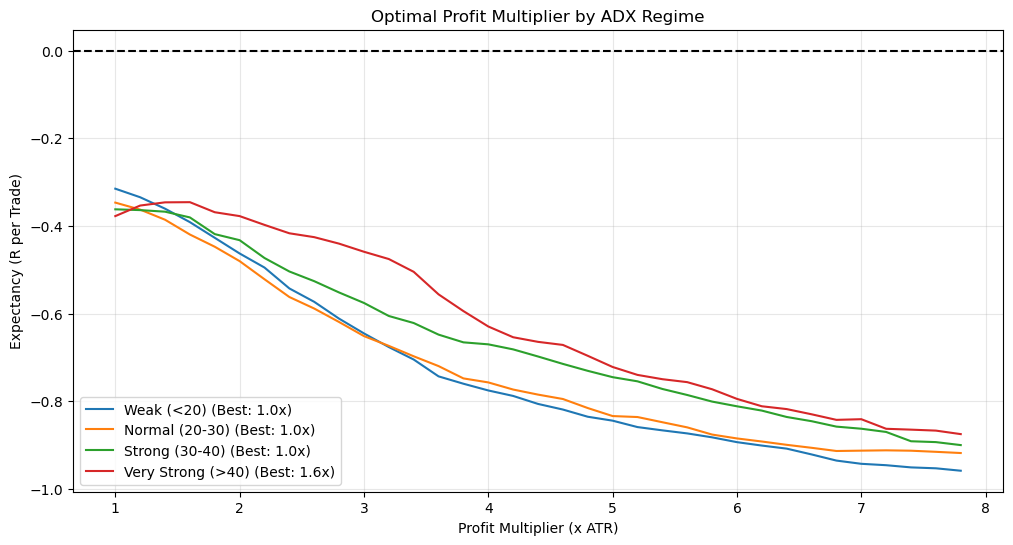

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def find_optimal_profit_multiplier(df, lookahead=10):
    print("🚀 Starting Grid Search for Optimal Profit Multipliers...")
    
    # 1. 데이터 준비 (Vectorized 연산을 위해 Numpy 배열로 변환)
    highs = df['ETH_High'].values
    lows = df['ETH_Low'].values
    closes = df['ETH_Close'].values
    atrs = df['ATR_84'].values
    adxs = df['ADX_14'].values
    
    # 미래 N기간 동안의 최고가 (High) 계산
    indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=lookahead)
    future_highs = df['ETH_High'].rolling(window=indexer).max().values
    future_lows = df['ETH_Low'].rolling(window=indexer).min().values
    
    # 2. 시뮬레이션 설정
    multipliers = np.arange(1.0, 8.0, 0.2) # 1.0배 ~ 8.0배 탐색
    adx_bins = [0, 20, 30, 40, 100]        # ADX 구간: 약함, 보통, 강함, 초강함
    bin_labels = ['Weak (<20)', 'Normal (20-30)', 'Strong (30-40)', 'Very Strong (>40)']
    
    results = []
    
    # 3. 그리드 서치 (이중 루프지만 벡터 연산이라 빠름)
    for i in range(len(adx_bins)-1):
        lower = adx_bins[i]
        upper = adx_bins[i+1]
        label = bin_labels[i]
        
        # 해당 ADX 구간에 해당하는 인덱스만 추출
        mask = (adxs > lower) & (adxs <= upper)
        if mask.sum() == 0: continue
        
        subset_atr = atrs[mask]
        subset_close = closes[mask]
        subset_future_high = future_highs[mask]
        subset_future_low = future_lows[mask]
        
        best_mult = 0
        max_expectancy = -999
        
        # 각 배수별로 테스트
        profits = []
        for m in multipliers:
            # 목표가 도달 여부 확인
            # Target Price = Entry + (ATR * Multiplier)
            targets = subset_close + (subset_atr * m)
            
            # 성공 여부: 기간 내 최고가가 타겟보다 높으면 성공
            # (단, 손절은 1.0배로 고정했다고 가정하고 단순화)
            stops = subset_close - (subset_atr * 1.0)
            stop_hit = subset_future_low <= stops
            target_hit = subset_future_high >= targets
            
            # 로직: 손절 안 당하고 타겟 쳤으면 수익, 아니면 손실
            # 수익 = m * ATR, 손실 = 1.0 * ATR
            
            # 손절이 먼저냐 익절이 먼저냐는 정밀하게 따지기 힘드므로
            # 보수적으로 "손절 닿았으면 무조건 실패"로 간주
            wins = target_hit & (~stop_hit)
            
            # 기대수익 계산 (Expectancy per Trade in 'R')
            # 승률 * (수익R) - 패율 * (손실R)
            win_rate = wins.mean()
            expectancy = (win_rate * m) - ((1 - win_rate) * 1.0)
            
            profits.append(expectancy)
            
            if expectancy > max_expectancy:
                max_expectancy = expectancy
                best_mult = m
        
        results.append({
            'ADX_Group': label,
            'Best_Mult': best_mult,
            'Max_Exp': max_expectancy,
            'Profits': profits
        })
        
        print(f"  [{label:<15}] Best Multiplier: {best_mult:.1f}x (Exp: {max_expectancy:.2f}R)")

    # 4. 시각화 (Heatmap 스타일)
    plt.figure(figsize=(12, 6))
    for res in results:
        plt.plot(multipliers, res['Profits'], label=f"{res['ADX_Group']} (Best: {res['Best_Mult']:.1f}x)")
    
    plt.axhline(0, color='black', linestyle='--')
    plt.title("Optimal Profit Multiplier by ADX Regime")
    plt.xlabel("Profit Multiplier (x ATR)")
    plt.ylabel("Expectancy (R per Trade)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# 실행
find_optimal_profit_multiplier(df)
